# Descriptive Text Mining

Programmazione di Applicazioni Data Intensive \
Laurea in Ingegneria e Scienze Informatiche  \
DISI - Università di Bologna, Cesena

Obiettivo: dai rapporti testuali redatti da National Transportation Safety Board che descrivono le cause di incidenti aerei, individuare, mediante analisi semantica con LSA, le cause che contribuiscono a provocare incidenti destroyed.

## Librerie impiegate

In [66]:
!pip install -U sklearn

In [48]:
from os import path, makedirs
from tabulate import tabulate
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import spacy

from matplotlib import pyplot as plt
from matplotlib.colors import from_levels_and_colors
import plotly.graph_objects as go
import plotly.express as px

from scipy import sparse
from scipy.stats import chi2_contingency
from scipy.io.arff import loadarff
# from scipy.sparse.linalg import svds

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics.pairwise import cosine_similarity

# plt.style.use('science')
IMAGES_PATH = "./"
makedirs(IMAGES_PATH, exist_ok = True)
get_path = lambda fname, format : path.join(IMAGES_PATH, fname + "." + format)
savefig = lambda fname, format : plt.savefig(get_path(fname, format), format = format)

## Funzioni impiegate

In [49]:
def plot_lsa(x,y,terms=None):
    fig = go.Figure()
    
    if terms is None:
        trace = go.Scatter(
            x=x,
            y=y,
            mode="markers+text",
            name="Markers and Text")
    else:
        trace = go.Scatter(
                    x=x,
                    y=y,
                    mode="markers+text",
                    name="Markers and Text",
                    text=terms,
            
                    textposition="bottom center",
                    textfont=dict(
                        family="sans serif",
                        size=9))

    fig.add_trace(trace)
    fig.update_layout(
        height=800,
        template = "none"
    )
    fig.update_traces(marker=dict(size=3,))
    return fig

In [50]:
def get_terms_arrays(x_coords, y_coords, vocabulary):
    lenght = len(vocabulary)
    x = np.zeros(lenght)
    y = np.zeros(lenght)

    for i, idx in enumerate(vocabulary.values()):
        x[i] = x_coords[idx]
        y[i] = y_coords[idx]
    
    if vocabulary is not None:
        terms = list(vocabulary.keys())
        return (x, y, terms)
    else:
        return (x, y)

In [51]:
def entropy(m, axis = 0):
    m = np.asarray(m)
    p = 1.0 * m / np.sum(m, axis = axis, keepdims = True)
    ndocs = m.shape[axis]
    vec = (p * np.log(p, out = np.zeros_like(p), where = (p!=0))) / np.log(ndocs)
    entropy = - np.sum(vec, axis = axis)
    return entropy

In [52]:
def get_word_counts(m, col_mask, row_mask):
    # get only doc_class related docs
    sliced = tdm[:, col_mask]
    
    # slice rows, get only columns with at least one of 
    # the entries in the row mask.
    sliced = sliced[row_mask, :]
    
    with_word = get_occ_word_all_docs(sliced)
    total = col_mask.sum()

    without_word = total - with_word
    return with_word, without_word

def get_occ_word_all_docs(sliced):
    # logical AND applied to all rows, one for each term
    # in the list, with a generator so that only two rows
    # at a time are loaded in memory.
    rows = [row for row in sliced]
    tmp = np.asarray(sliced[0])
    for row in rows:
        b = np.logical_and(tmp, row)
        tmp = b
    b = np.asarray(b)[0]
    return b.sum()

In [53]:
def term_analysis(
    terms,
    doc_classes,
    without_word_in,
    with_word_in,
    without_word_out,
    with_word_out):  
    
    get_term_doc_df = \
        lambda data, terms, doc_classes : pd.DataFrame(
            data,
            index = [f"not {terms}", f"{terms}"], 
            columns = [f"not {doc_classes}", f"{doc_classes}"]
        )   
    
    terms = "_".join(terms)
    doc_classes = "_".join(doc_classes)
    
    observed = [
        [without_word_out, without_word_in],
        [with_word_out, with_word_in]
    ]
    observed = get_term_doc_df(observed, terms, doc_classes)

    chi2, p, ddof, expected = chi2_contingency(
        observed,
        correction = False
    )
    expected = get_term_doc_df(expected, terms, doc_classes)

    print(f"Pearson's Chi-squared test with {ddof} ddof")
    print("--------------------------------------\n")
    print("Observed frequencies") 
    print(tabulate(observed, headers='keys', tablefmt='psql'))
    print("\nExpected frequencies")
    print(tabulate(expected, headers='keys', tablefmt='psql'))
    print(f"\nX-squared: \t{chi2}")
    print(f"p-value \t{p}")

In [123]:
def get_similar_term2term(m, term, term_id, terms, threshold = 0, topn = 10):
    if threshold >= 1.0 or threshold < 0:
        raise("Threshold must be in (0,1]")
    
    terms = np.asarray(terms)
    terms = terms.reshape(terms.shape[0], 1)
    arr = np.asarray(m[term_id, ]).reshape(1, m.shape[1])
    term2term = cosine_similarity(arr, m)
    term2term = term2term.T
    
    mask = term2term > threshold
    term2term_masked = term2term[mask]
    terms_masked = terms[mask]
    
    terms_idx = [idx for idx, elem in enumerate(mask) if elem == 1]
            
    dtype = [("id", int), ("term", "U20"), ("sim_val", float)]
    ranks = [(z, y, x) for x, y, z in zip(term2term_masked, terms_masked, terms_idx)]
    ranks = np.array(ranks, dtype = dtype) # use a structured array
    ranks = np.sort(ranks, order = "sim_val")
    ranks = ranks[::-1]  # terms in decreasing order
    ranks = ranks[1:]    # exclude term used for search
    
    nranks = len(ranks)
    if topn < nranks:
        ranks = ranks[:topn] # show only first top n matches
        print(f"First {topn} of {nranks} matches")
    else:
        print(f"Showing all {nranks} matches")
    return list(ranks)

In [55]:
def get_similar_query2docs(m, q, docs, threshold = 0, topn = 10):
    if threshold >= 1.0 or threshold < 0:
        raise("Threshold must be in (0,1]")
    
    docs = np.asarray(docs).reshape(docs.shape[0], 1)
    q = np.asarray(q).reshape(1, m.shape[1])
    query2doc = cosine_similarity(q, m)
    query2doc = query2doc.T
    
    mask = query2doc > threshold
    query2doc_masked = query2doc[mask]
    docs_masked = docs[mask]

    docs_idx = [idx for idx, elem in enumerate(mask) if elem == 1]
       
    # use a structured array
    dtype = [("id", int), ("doc", "U500"), ("sim_val", float)]
    ranks = [(z, y, x) for x, y, z in zip(query2doc_masked, docs_masked, docs_idx)]
    ranks = np.array(ranks, dtype = dtype)
    ranks = np.sort(ranks, order = "sim_val")
    ranks = ranks[::-1]  # docs in decreasing order
    
    nranks = len(ranks)
    if topn < nranks:
        ranks = ranks[:topn] # show only first top n matches
        print(f"First {topn} of {nranks} matches")
    else:
        print(f"Showing all {nranks} matches")
    return list(ranks)

## Caricamento dei dati

In [56]:
dataset_url = "https://raw.githubusercontent.com/Da3dalu2/thesis-notebooks/main/ntsb-causes.csv"
dataset_name = "ntsb-causes.csv"

if not path.exists(dataset_name):
    urlretrieve(dataset_url, dataset_name)

df = pd.read_csv('ntsb-causes.csv')  
df.columns = types

In [57]:
df

,damage_class,narr_causes
0,Substantial,The pilot failed to maintain directional contr...
1,Substantial,The pilot's failure to maintain directional co...
2,Destroyed,The failure of the student pilot to maintain a...
3,Substantial,The failure of the pilot to obtain assistance ...
4,Substantial,The pilot's failure to maintain a proper glide...
...,...,...
3224,Substantial,The pilot's failure to properly secure an aeri...
3225,Substantial,the pilot's inadequate compensation for the gu...
3226,Substantial,The student's failure to maintain adequate mai...
3227,Substantial,The certified flight instructor (CFI) delayed ...


In [58]:
damage_class = list(df.damage_class.unique())

In [59]:
fig = go.Figure(
    data = [go.Pie(labels = damage_class,
            values = df.damage_class.value_counts(),
            marker = dict(colors = px.colors.qualitative.Bold),
            hole = .3)]
)

fig.update_layout(title = "Distribuzione dell'esito degli incidenti aerei")
fig.show()

## Costruzione della matrice termini documenti

In [60]:
excluded = [
#     "tok2vec",
#     "tagger",
#     "parser",
    "ner",
#     "attribute_ruler",
#     "lemmatizer"
]
nlp = spacy.load("en_core_web_sm", exclude=excluded)
# nlp.Defaults.stop_words |= {"effect", "effects"}

In [61]:
def spacy_tokenizer(sentence):
    sentence = nlp(sentence)
    tokens = [token.lemma_.lower() for token in sentence 
          if token.is_stop == False 
          and token.is_digit == False
          and token.is_punct == False
          and len(token.text) > 2
          and token.is_ascii == True
          and token.is_alpha == True
          and token.is_quote == False
          and token.is_space == False
          and token.is_currency == False
          and token.like_email == False
          and token.like_num == False
          and token.like_url == False
#           and token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']
         ]
    return tokens

In [62]:
df.columns

Index(['damage_class', 'narr_causes'], dtype='object')

In [68]:
vect = CountVectorizer(
    lowercase = True,
    strip_accents = "ascii",
    tokenizer = spacy_tokenizer, min_df = 32
)
dtm = vect.fit_transform(df.narr_causes)

In [64]:
dtm

<3229x201 sparse matrix of type '<class 'numpy.int64'>'
	with 35379 stored elements in Compressed Sparse Row format>

In [70]:
len(vect.get_feature_names())

201

In [73]:
ord_terms = vect.get_feature_names()

In [74]:
vocabulary = vect.vocabulary_

In [75]:
dtm.astype(bool).mean()

0.05451066131097378

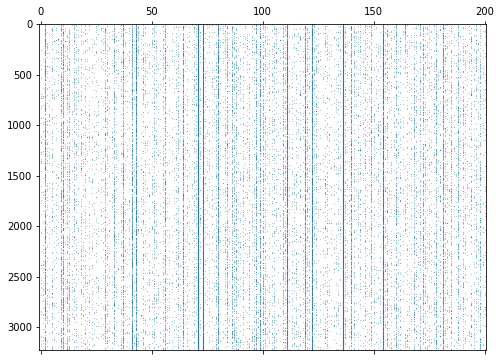

In [76]:
fig = plt.figure()
plt.spy(dtm, markersize=0.10, aspect = 'auto')
fig.set_size_inches(8,6)

In [77]:
tdm = dtm.transpose()

In [78]:
tdm

<201x3229 sparse matrix of type '<class 'numpy.int64'>'
	with 35379 stored elements in Compressed Sparse Column format>

In [79]:
tdm = tdm.todense()

In [80]:
b = (1 - entropy(tdm, axis = 1))
b = np.array(b)
b.shape

(201,)

In [81]:
a = np.log(tdm + 1)
a = np.array(a)
a.shape

(201, 3229)

In [82]:
# adding a nonzero scalar to a sparse matrix is not supported
tdmw = (a.T * b).T

In [83]:
tdmw.shape

(201, 3229)

## Analisi semantica latente

In [84]:
tdmw = sparse.csr_matrix(tdmw)
tdmw

<201x3229 sparse matrix of type '<class 'numpy.float64'>'
	with 35379 stored elements in Compressed Sparse Row format>

In [85]:
U, s, Vh = randomized_svd(tdmw, n_components = 69, random_state = 5)

In [86]:
s.shape

(69,)

In [87]:
U.shape

(201, 69)

In [88]:
Vh.shape

(69, 3229)

In [89]:
Vh = Vh.transpose()

In [90]:
Vh.shape

(3229, 69)

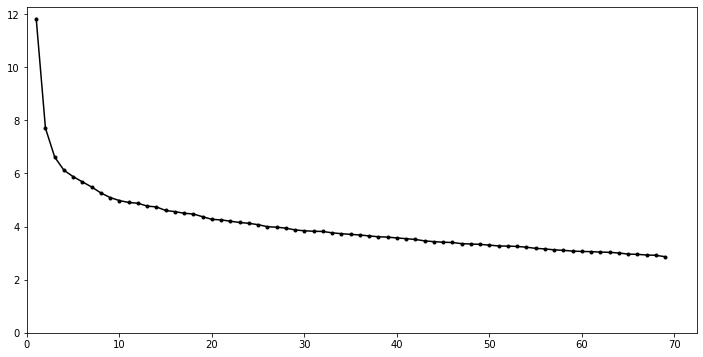

In [91]:
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(1, 69, 69), s, "k.-")
plt.ylim(bottom=0)
plt.xlim(xmin=0)
savefig("power_law_svd", "pdf")

In [92]:
# U è chiamata tk (lsar$tk), S è sk (lsar$sk), V^t è dk (lsar$dk)
tls = np.matmul(U, np.diag(s))
dls = np.matmul(Vh, np.diag(s))

In [93]:
tls.shape

(201, 69)

In [94]:
dls.shape

(3229, 69)

## Visualizzazione dello spazio trasformato

In [95]:
# tls

In [96]:
get_norm = lambda v : np.sqrt(np.sum(np.power(v, 2)))

In [97]:
terms_norm_lsa = np.zeros(len(tls[:,]))
for idx, col in enumerate(tls):
    terms_norm_lsa[idx] = get_norm(col)

In [98]:
# terms_norm_lsa

In [99]:
tls_terms_norm = np.column_stack((tls, terms_norm_lsa))
tls_terms_norm.shape

(201, 70)

Visualizzazione dei termini nelle prime due dimensioni latenti

In [100]:
x, y, terms = get_terms_arrays(tls[:,0], tls[:,1], vocabulary)
plot_lsa(-1*x, -1*y, terms) \
    .update_layout(title_text = "Visualizing LSA") \
    .show()

In [101]:
tls.shape

(201, 69)

In [102]:
vocabulary_reduced = {}
for term, idx in vocabulary.items():
    if tls_terms_norm[idx][69] > 1.25: 
        vocabulary_reduced[term] = idx

In [103]:
len(vocabulary_reduced)

178

In [104]:
x.shape

(201,)

In [105]:
x, y, terms = get_terms_arrays(tls[:,0], tls[:,1], vocabulary_reduced)
plot_lsa(-1*x, -1*y, terms) \
    .update_layout(title_text = "Visualizing LSA on a subset") \
    .show()

In [106]:
plot_lsa(-1*dls[:,0], -1*dls[:,1]) \
    .update_layout(title_text = "Visualizing LSA of documents") \
    .show()

In [107]:
x, y, terms = get_terms_arrays(tls[:,1], tls[:,2], vocabulary)
plot_lsa(-1*x, y, terms) \
    .update_layout(title_text = "Visualizing LSA") \
    .show()

In [108]:
plot_lsa(-1*dls[:,1], dls[:,2]) \
    .update_layout(title_text = "Visualizing LSA of documents") \
    .show()

## Distribuzione delle tipologie di incidenti

In [109]:
df.damage_class.value_counts()

Substantial    2574
Destroyed       482
None             91
Minor            82
Name: damage_class, dtype: int64

In [110]:
dls.shape

(3229, 69)

In [111]:
df

,damage_class,narr_causes
0,Substantial,The pilot failed to maintain directional contr...
1,Substantial,The pilot's failure to maintain directional co...
2,Destroyed,The failure of the student pilot to maintain a...
3,Substantial,The failure of the pilot to obtain assistance ...
4,Substantial,The pilot's failure to maintain a proper glide...
...,...,...
3224,Substantial,The pilot's failure to properly secure an aeri...
3225,Substantial,the pilot's inadequate compensation for the gu...
3226,Substantial,The student's failure to maintain adequate mai...
3227,Substantial,The certified flight instructor (CFI) delayed ...


In [112]:
dfc = pd.DataFrame(
    {"Esito incidente" : df.damage_class,
     "dls[:,1]" : -1*dls[:,1],
     "dls[:,2]" : dls[:,2]}
)

In [113]:
fig = px.scatter(
    dfc,
    x="dls[:,1]",
    y="dls[:,2]",
    color="Esito incidente",
    template="none",
    height=800
)
    
fig.update_traces(marker=dict(size=3,))
fig.show()

In [114]:
# x, y, terms = get_terms_arrays(tls[:,0], tls[:,1], vocabulary_reduced)

## Analisi termini e documenti

In [115]:
from numpy.linalg import norm

In [116]:
tlsn = norm(tls, 2, axis = 1)
dlsn = norm(dls, 2, axis = 1)
tlsn = tls / tlsn[:,None]
dlsn = dls / dlsn[:,None]

In [117]:
dfc = pd.DataFrame(
    {"Esito incidente" : df.damage_class,
     "dls[:,1]" : -1*dlsn[:,1],
     "dls[:,2]" : dlsn[:,2]}
)

In [118]:
x, y, terms = get_terms_arrays(-1*tlsn[:,1], tlsn[:,2], vocabulary)

In [119]:
fig = px.scatter(
    dfc,
    x = "dls[:,1]",
    y = "dls[:,2]",
    color = "Esito incidente",
    template = "none",
    height = 800
)

terms_trace = go.Scatter(
    x = x,
    y = y,
    mode = "markers+text",
    name = "terms",
    text = terms,
    textposition = "bottom center",
    textfont = 
        dict(
            family = "sans serif",
            size = 9
        )
)
    
fig.add_trace(terms_trace)
fig.update_traces(marker=dict(size=3,))
fig.show()

## Analisi del termine weather

Tramite il test $\chi^2$ è possibile determinare se l'occorrenza del termine "weight" nei documenti relativi al coumadin è statisticamente significativa. La funzione non calcola automaticamente le frequenze attese a partire da quelle osservate. Si ottiene la probabilità che il termine weight non sia correlato alle recensioni del coumadin. In base al valore del p value ottenuto si può rifiutare l'ipotesi nulla secondo cui il termine "weight" non è correlato al coumadin.

In [120]:
terms = ["weather"]
doc_classes = ["Destroyed"]

doc_idx = np.asarray(df.damage_class == doc_classes[0])
doc_mask = doc_idx != 0

term_idx = [vocabulary.get(term) for term in terms]
term_mask = np.asarray(
    [True if i in term_idx else False for i in range(0, tdm.shape[0])]
)

with_word_in, without_word_in = get_word_counts(tdm, doc_idx, term_mask)

doc_mask = ~doc_mask

with_word_out, without_word_out = get_word_counts(tdm, doc_mask, term_mask)

term_analysis(
    terms,
    doc_classes,
    without_word_in,
    with_word_in,
    without_word_out,
    with_word_out
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+-------------+-----------------+-------------+
|             |   not Destroyed |   Destroyed |
|-------------+-----------------+-------------|
| not weather |            2664 |         428 |
| weather     |              83 |          54 |
+-------------+-----------------+-------------+

Expected frequencies
+-------------+-----------------+-------------+
|             |   not Destroyed |   Destroyed |
|-------------+-----------------+-------------|
| not weather |         2630.45 |    461.55   |
| weather     |          116.55 |     20.4503 |
+-------------+-----------------+-------------+

X-squared: 	67.56407215908636
p-value 	2.0395037376620448e-16


In [121]:
m = tls[:,1:3]
term = "weather"
term_id = vocabulary.get(term)

In [124]:
ranks = get_similar_term2term(
    m,
    term,
    term_id,
    ord_terms,
    threshold = 0.8,
    topn = 20
)
ranks

First 20 of 56 matches


[(81, 'fly', 0.99978763),
 (107, 'intentional', 0.99939007),
 (11, 'airport', 0.99894521),
 (29, 'clearance', 0.99871452),
 (7, 'adverse', 0.99794421),
 (114, 'light', 0.99769867),
 (13, 'altitude', 0.99689543),
 (82, 'fog', 0.99623428),
 (124, 'maneuver', 0.99580872),
 (106, 'instrument', 0.99574916),
 (27, 'ceiling', 0.99564839),
 (193, 'vfr', 0.99503707),
 (125, 'meteorological', 0.993456),
 (108, 'know', 0.99322637),
 (80, 'flight', 0.99090945),
 (185, 'tree', 0.989839),
 (16, 'area', 0.98926722),
 (40, 'continue', 0.98920988),
 (120, 'low', 0.98746888),
 (65, 'evaluation', 0.98685863)]

In [125]:
terms = ["adverse", "weather"]
doc_classes = ["Destroyed"]

doc_idx = np.asarray(df.damage_class == doc_classes[0])
doc_mask = doc_idx != 0

term_idx = [vocabulary.get(term) for term in terms]
term_mask = np.asarray(
    [True if i in term_idx else False for i in range(0, tdm.shape[0])]
)

with_word_in, without_word_in = get_word_counts(tdm, doc_idx, term_mask)

doc_mask = ~doc_mask

with_word_out, without_word_out = get_word_counts(tdm, doc_mask, term_mask)

term_analysis(
    terms,
    doc_classes,
    without_word_in,
    with_word_in,
    without_word_out,
    with_word_out
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+---------------------+-----------------+-------------+
|                     |   not Destroyed |   Destroyed |
|---------------------+-----------------+-------------|
| not adverse_weather |            2724 |         457 |
| adverse_weather     |              23 |          25 |
+---------------------+-----------------+-------------+

Expected frequencies
+---------------------+-----------------+-------------+
|                     |   not Destroyed |   Destroyed |
|---------------------+-----------------+-------------|
| not adverse_weather |       2706.17   |   474.835   |
| adverse_weather     |         40.8349 |     7.16507 |
+---------------------+-----------------+-------------+

X-squared: 	52.97079799097852
p-value 	3.3854428665485344e-13


## Costruzione dell'interrogazione

A questo punto, ripeto l'analisi nello spazio LSA, per stabilire oggettivamente se esiste anche una correlazione semantica tra la coppia di termini "gain weight" e le recensioni sugli effetti collaterali del farmaco Coumadin. In questo caso i documenti considerati potrebbero anche non contenere i due termini specifici, ma termini semanticamente correlati ad essi.

Per fare questo, trasformo la query "gain weight" in un documento e faccio fold in nello spazio LSA.

In [126]:
q = "adverse weather"

In [128]:
length = tdm.shape[0]
query = np.zeros(length)
for term in [vocabulary.get(term) for term in terms]:
    query[term] = 1
query.shape

(201,)

In [129]:
wquery = np.log(query + 1) * (1 - entropy(tdm, axis = 1))
wquery.shape

(201,)

In [130]:
qls = np.matmul(wquery.T, U)
qls.shape

(69,)

In [131]:
qlsn = norm(qls, 2)
qlsn = qls / qlsn

In [132]:
qlsn

array([ 0.09050336, -0.10816458, -0.24397064, -0.01145749,  0.09110184,
        0.19291453,  0.08443872, -0.1892384 ,  0.0778919 , -0.10129252,
        0.00302347,  0.0161657 ,  0.10729703, -0.24828779, -0.10572164,
       -0.07184534,  0.03539552,  0.08734467, -0.15702332, -0.12745915,
        0.02853997, -0.17592283, -0.31408667, -0.0562162 , -0.02518481,
        0.117275  , -0.01762206,  0.04367047,  0.43887981, -0.02428118,
       -0.1633371 , -0.18005113, -0.16693868,  0.25088954,  0.07299071,
       -0.04674863,  0.02321041, -0.00628659, -0.15150884, -0.11047272,
        0.0093684 , -0.09730733,  0.01368289, -0.13325371,  0.00353969,
        0.09702164,  0.04881098,  0.10820514,  0.01254377, -0.1078184 ,
       -0.08055315,  0.11750744, -0.0258618 ,  0.0723591 ,  0.08815894,
       -0.02295942, -0.02241215,  0.05035493, -0.05941826,  0.07348692,
       -0.04861525,  0.07075622, -0.02285792,  0.03170696,  0.09345443,
       -0.00508309,  0.08569543,  0.07097537, -0.01632369])

In [133]:
qlsn[2]

-0.24397064070910565

In [134]:
qlsn[3]

-0.011457488229735803

In [135]:
x, y, terms = get_terms_arrays(-1*tlsn[:,1], tlsn[:,2], vocabulary)

In [136]:
fig = px.scatter(
    dfc,
    x = "dls[:,1]",
    y = "dls[:,2]",
    color = "Esito incidente",
    template = "none",
    height = 800
)

terms_trace = go.Scatter(
    x = x,
    y = y,
    mode = "markers+text",
    name = "terms",
    text = terms,
    textposition = "bottom center",
    textfont = 
        dict(
            family = "sans serif",
            size = 9
        )
)

query_trace = go.Scatter(
    x = [-1*qlsn[1]],
    y = [qlsn[2]],
    mode = "markers",
    name = "query",
    marker = dict(
        size = 12,
        color = "black",
        symbol = "x"
    )
)

fig.add_trace(terms_trace)
fig.update_traces(marker=dict(size=3,))
fig.add_trace(query_trace)
fig.show()

In [137]:
m = dls[:,1:3]
q = qlsn[1:3]
docs = df.narr_causes

ranks = get_similar_query2docs(
    m,
    q,
    docs,
    threshold = 0.8,
    topn = 10
)
print([rank[0] for rank in ranks])
[rank[2] for rank in ranks]

First 10 of 628 matches
[1228, 941, 209, 1830, 763, 387, 1040, 83, 406, 2280]


[0.9999999845299505,
 0.9999996208437903,
 0.999999569291146,
 0.9999994478122793,
 0.9999992820627938,
 0.9999985748313582,
 0.9999983525964099,
 0.9999969277783234,
 0.9999947528781158,
 0.9999927998549831]

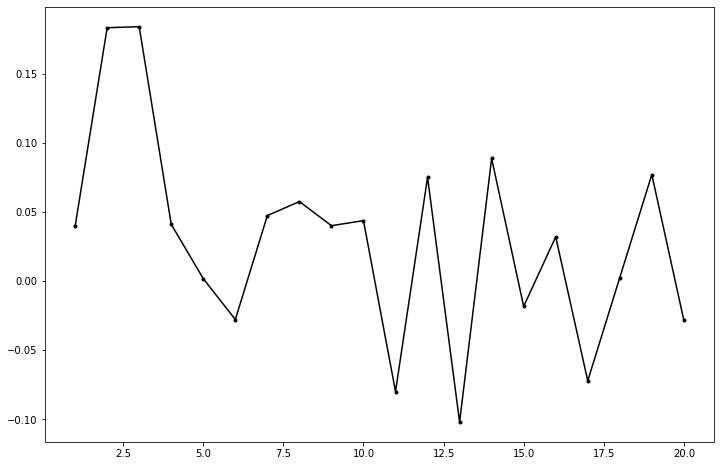

In [138]:
fordiff = lambda x : x[1:len(x)] - x[0:(len(x) - 1)]
skd = fordiff(s)
skdd = fordiff(skd)
skcurv = skdd[0:20] / np.power(1 + np.power(skd[0:20], 2), 1.5)

plt.figure(figsize=(12, 8))
plt.plot(np.linspace(1, 20, 20), skcurv, "k.-")
savefig("knee_points_svd", "pdf")

In [149]:
m = dls[:,0:7]
q = qlsn[0:7]
docs = df.narr_causes

ranks = get_similar_query2docs(
    m,
    q,
    docs,
    threshold = 0.2,
    topn = 482
)
query_matching_idxs = [rank[0] for rank in ranks]
sim_scores = [rank[2] for rank in ranks]

First 482 of 1020 matches


["The pilot's disregard of  the weather evaluation and his attempt to fly into known adverse weather without an instrument rating.  Factors in the accident were the low ceiling, the low visibility, and the icing conditions.",
 "The pilot's continued flight into known adverse weather.  A factor was the snow.",
 "the pilot's inadverent VFR flight into instrument meteorological weather conditions which resulted in an in-flight collision with terrain.  Contributing factors were the night light conditions and the clouds.",
 "The pilot's continued flight into adverse weather conditions after becoming lost/disoriented.  Factors in the accident were rising terrain, a blind/box canyon, low clouds, and rain.",
 "The pilot's poor judgment in that he intentionally initiated VFR flight into instrument meteorological conditions.  Contributing factors were low ceiling and obscuration, and the pilot's lack of recent instrument time.",
 "The pilot's failure to maintain clearance with terrain and contin

In [150]:
[rank[1] for rank in ranks[:10]]

["The pilot's disregard of  the weather evaluation and his attempt to fly into known adverse weather without an instrument rating.  Factors in the accident were the low ceiling, the low visibility, and the icing conditions.",
 "The pilot's continued flight into known adverse weather.  A factor was the snow.",
 "the pilot's inadverent VFR flight into instrument meteorological weather conditions which resulted in an in-flight collision with terrain.  Contributing factors were the night light conditions and the clouds.",
 "The pilot's continued flight into adverse weather conditions after becoming lost/disoriented.  Factors in the accident were rising terrain, a blind/box canyon, low clouds, and rain.",
 "The pilot's poor judgment in that he intentionally initiated VFR flight into instrument meteorological conditions.  Contributing factors were low ceiling and obscuration, and the pilot's lack of recent instrument time.",
 "The pilot's failure to maintain clearance with terrain and contin

In [140]:
df.narr_causes[1792]

"The pilot's continued flight into known adverse weather.  A factor was the snow."

In [141]:
df.damage_class[query_matching_idxs[0:10]].value_counts()

Destroyed      5
Substantial    5
Name: damage_class, dtype: int64

In [142]:
df.damage_class.value_counts()

Substantial    2574
Destroyed       482
None             91
Minor            82
Name: damage_class, dtype: int64

In [143]:
df.damage_class[query_matching_idxs].value_counts()

Substantial    294
Destroyed      156
None            24
Minor            8
Name: damage_class, dtype: int64

In [144]:
doc_classes = ["Destroyed"]
terms = ["adverse", "weather"]
destroyed_idx = np.asarray(df.damage_class == doc_classes[0])
doc_mask = destroyed_idx != 0

query_mask = np.asarray(
    [True if i in query_matching_idxs else False for i in range(0, dls.shape[0])]
)

mask = np.logical_and(doc_mask, query_mask)
total = doc_mask.sum()
with_word_in = mask.sum()
without_word_in = total - with_word_in

doc_mask = ~doc_mask
mask = np.logical_and(doc_mask, query_mask)
total = doc_mask.sum()
with_word_out = mask.sum()
without_word_out = total - with_word_out

term_analysis(
    terms,
    doc_classes,
    without_word_in,
    with_word_in,
    without_word_out,
    with_word_out
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+---------------------+-----------------+-------------+
|                     |   not Destroyed |   Destroyed |
|---------------------+-----------------+-------------|
| not adverse_weather |            2421 |         326 |
| adverse_weather     |             326 |         156 |
+---------------------+-----------------+-------------+

Expected frequencies
+---------------------+-----------------+-------------+
|                     |   not Destroyed |   Destroyed |
|---------------------+-----------------+-------------|
| not adverse_weather |        2336.95  |    410.051  |
| adverse_weather     |         410.051 |     71.9492 |
+---------------------+-----------------+-------------+

X-squared: 	135.66766062642319
p-value 	2.358845452535434e-31


In [145]:
destroyed_entries = np.asarray(
    [1 if destroyed_idx[idx] == 1 else 0 for idx in query_matching_idxs]
)

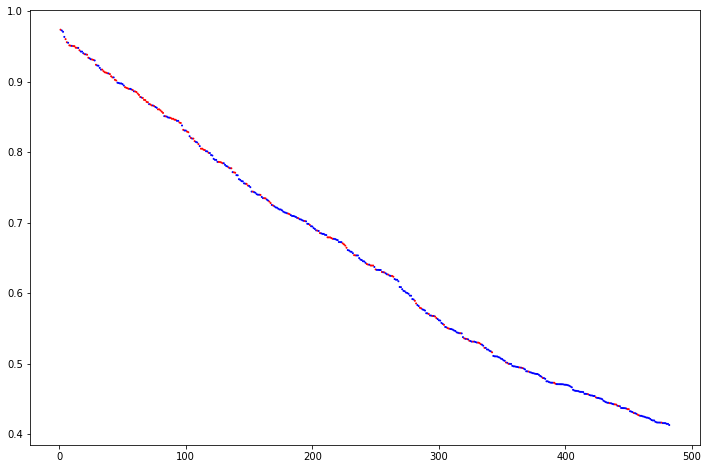

In [146]:
plt.figure(figsize=(12, 8))
plt.scatter(
    np.linspace(1, 482, 482),
    sim_scores,
    c = destroyed_entries,
    marker = "o",
    cmap = "bwr",
    s = 1
)
plt.show()